In [1]:
import numpy as np 
from scipy import ndimage
from scipy.ndimage import convolve
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from math import exp
import os

ATTENTION : Il faut nécessairement la version 1.20.0 de numpy et 3.5.1 de matplotlib pour exécuter le code suivant 

# 1A ModIA : Projet Detection de Contours 



* MUSSARD Cassandra 
* GHAMNIA Karima 
* COLIN Rémi 
* SONG Mickael

Ce projet combine différentes méthodes et techniques de traitement de signal et d'apprentissage automatique pour de la détection de contours. 

Dans un premier temps, on a commencé par parcourir les méthodes mathématiques les plus utilisées dans le domaine : Convolutions avec différents filtres (Sobel, Prewitt,..) pour calculer le gradient, le Laplacien, et la transformée de Hough.

Ensuite, on a utilisé des méthodes de Machine Learning: CNN, Random Forest, et Fine Tuning. Enfin, on a comparé les différents méthodes utilisées sur l'image ('lena.png')



# I - Détection de contours avec les méthodes classiques

### 1 - Méthodes basées sur le calcul du gradient :

Le calcul du gradient, est une des techniques les plus utilisées en traitement d'images pour la détection de contours. En calculant le gradient d'une image, on mesure la variation des pixels de cette dernière, ce qui permets d'identifier les changements d'intensité significatifs entre les pixels. 

Pour cela, on effectue des convolutions avec des filtres qui permettent de calculer la dérivée première de l'image. Dans ce notebook, on a utilisé les opérateurs suivants: Roberts, Prewitt et Sobel.

vecteur

Il est caractérisé par un module $G$ et une direction $\phi$ dans l’image :

$$ G = \sqrt{ (\frac{\delta{I(x,y)^2}}{\delta{x}} + \frac{\delta{I(x,y)}^2}{\delta{y}} )}$$

$$\phi = arctan(\frac{\delta{I(x,y)}}{\delta{x}} / \frac{\delta{I(x,y)}}{\delta{y}} )$$ 


## STEP 0 : Filtre gaussien 

D'abord, avant d'appliquer les différentes méthodes de détection de contours, on va toujours commencer par filtrer l'image d'origine, afin d'enlever le bruit ainsi que les détails indésirables de l'image, qui parfois peuvent conduire à une détection de contour érronée. On choisit donc d'utiliser un filtre gaussien qui va atténuer toutes variation indésirable avant de passer aux caluculs du gradient. 

On utilise un filtre gaussien pour sa distribution de probabilité normale, ce qui permet d'avoir un équilibre entre la suppression du bruit et la préservation des contours importants. D'autres filtres passe-bas peuvent être utilisés également.

Le filtre gaussien dans la suite, est définie par une matrice où chaque pixel a une valeur déterminée par la formule : 

$$ element(i,j) = exp  (-\frac{(i-x)^2+(j-y)^2}{2\sigma^2})$$

où $(x, y)$ est le centre du filtre et $\sigma$ est l'écart-type, qui contrôle la largeur de la distribution gaussienne.

In [2]:
def gaussian_kernel(image, kernel_size, sigma):
    kernel = np.empty((kernel_size, kernel_size))
    coeff_normalisant = 1 / (2.0 * np.pi * sigma**2)
    for i in range(kernel.shape[0]) :
        for j in range(kernel.shape[1]) :
            kernel[i,j] = coeff_normalisant*exp(-((i**2 + j**2) / (2.0*sigma**2))) 
    img_smoothed = convolve(image, kernel, mode='constant', cval=0.0)
    return img_smoothed

In [3]:
# Pour afficher les images 
def affiche(im1, im2):
    fig = plt.figure(figsize=(10, 5))
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    # Afficher la première image 
    ax1 = fig.add_subplot(grid[0, 0])
    ax1.imshow(im1, cmap='gray')

    # Afficher la deuxième image 
    ax2 = fig.add_subplot(grid[0, 1])
    ax2.imshow(im2, cmap='gray')

In [4]:
current_path = os.getcwd()
image = Image.open(current_path+'/lena.png')
image_niveau_gris = image.convert('L')
filtered_img = gaussian_kernel(image_niveau_gris, 10 ,10)

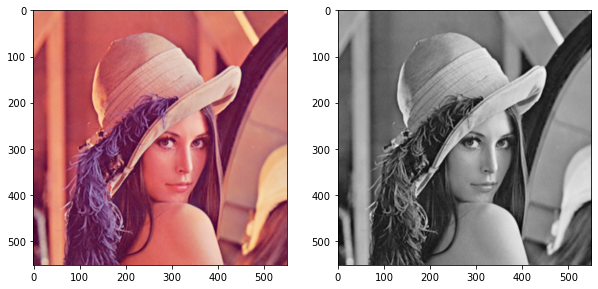

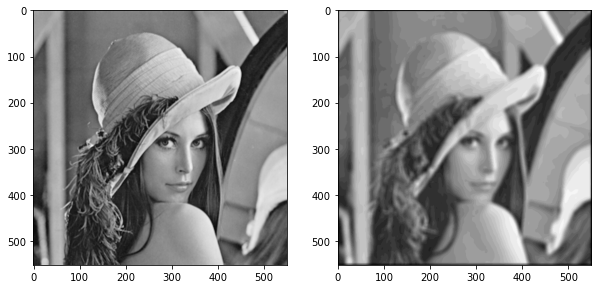

In [5]:
affiche(image, image_niveau_gris)
affiche(image_niveau_gris, filtered_img)

#### 1.1 - Opérateur de Roberts 
Cet opérateur utilise deux masques pour la détections de contours diagonaux. Ces masques sont les suivants :

$$ h_1 = \begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}$$

$$ h_2 = \begin{pmatrix}
0 & 1\\
-1 & 0
\end{pmatrix}$$

Ce filtre est assez simple, mais moins précis que d'autres opérateurs plus avancés. On peut l'utiliser comme une étape préliminaire dans des méthodes de détection de contours plus complexes.

In [6]:
def roberts_filters(image) :
    K_diag1 = np.array([[0,1],[-1,0]], np.float32)
    K_diag2 = np.array([[1,0],[0,-1]], np.float32)
    
    I_diag1 = convolve(image, K_diag1)
    I_diag2 = convolve(image, K_diag2)
    
    Gradient = np.sqrt(I_diag1**2 + I_diag2**2)
    theta = np.arctan2(I_diag2, I_diag1)
    
    return Gradient, theta

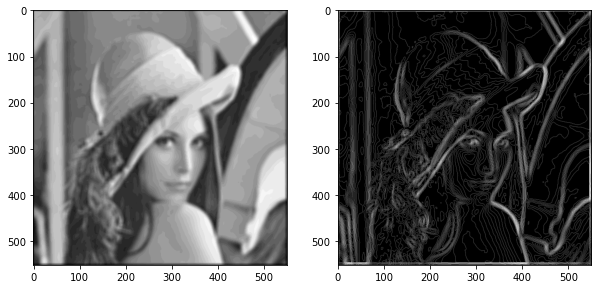

In [7]:
grad_roberts, angle= roberts_filters(filtered_img)
affiche(filtered_img, grad_roberts)

### 1.2 - Opérateur de Prewitt et de Sobel

Le calcul de gradient de ces 2 opérateurs est mené par l'intermédiaire de deux masques, le premier effectuant un gradient
horizontal, le second un gradient vertical.
Ces masques ont l'avantage de produire deux effets : le calcul du gradient dans une direction et un lissage dans la direction orthogonale. Ce lissage rend ces masques un peu moins
sensibles au bruit que le filtre de Roberts.

#### 1.2.1 - Prewitt


$$ h_1 = 1/3 \begin{pmatrix}
-1 & 0 & 1\\
-1 & 0 & 1\\
-1 & 0 & 1\\
\end{pmatrix}$$


$$ h_2 = 1/3 \begin{pmatrix}
-1 & -1 & -1\\
0 & 0 & 0\\
1 & 1 & 1\\
\end{pmatrix}$$

In [9]:
def prewitt_filters(image) :
    Kx = (1/3)*np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) #On normalise par 1/3
    Ky = (1/3)*np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    
    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)
    
    Gradient = np.sqrt(Ix**2 + Iy**2)
    theta = np.arctan2(Iy, Ix)
    
    return Gradient, theta

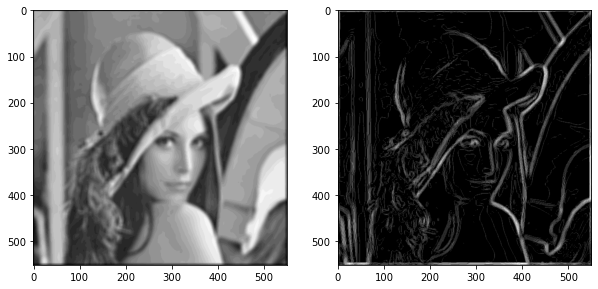

In [10]:
grad_prewitt, angle= prewitt_filters(filtered_img)
affiche(filtered_img, grad_prewitt)

#### 1.2.2 - Sobel
$$ h_1 = 1/4 \begin{pmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1\\
\end{pmatrix}$$


$$ h_2 = 1/4 \begin{pmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1\\
\end{pmatrix}$$

In [11]:
def sobel_filters(image):
    Kx = (1/4)*np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

    Ky = (1/4)*np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    
    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)

    
    G = np.hypot(Ix, Iy) #fonction qui calcule la norme euclidienne
    #G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return Ix, Iy, G, theta

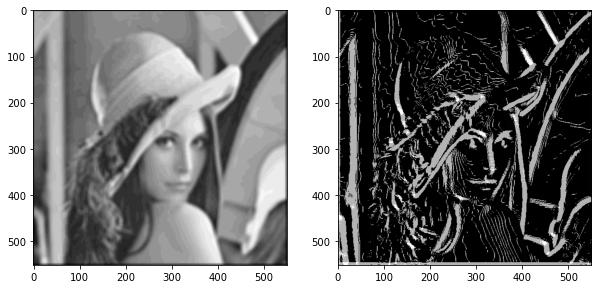

In [12]:
_, y, grad_sobel, angle= sobel_filters(filtered_img)
affiche(filtered_img, grad_sobel)

Il existe bien sûr beaucoup d'autres masques utilisés pour déterminer le gradient d'une image.
On utilisera par la suite le filtre de Sobel par son efficacité.

### 2 - Filtre de Canny
Le filtre de Canny est un algorithme de détection de contour développé par John Canny en 1986. C'est la méthode la plus utilisée et précise dans la détection de contours, elle est basée sur le calcul du gradient avec un filtre de Sobel. 

Canny a proposé un filtre déterminé analytiquement à partir de 3 critères :


1 - garantir une bonne détection, c’est-à-dire une réponse forte même à de faibles contours


2 - garantir une bonne localisation


3 - assurer que pour un contour il n’y aura qu’une seule détection (éviter les effets de rebonds dus par exemple,à la troncature des filtres)

Ce filtre est réalisé en 4 étapes + l'étape 0 qu'on a déja vu précédemment : le filtre gaussien

#### 2.1 -  STEP 1 : Calcul du gradient avec le filtre de Sobel 
Comme on l'a également vu précédemment, le gradient de l'image filtrée se calcule par une convolution avec un filtre de Sobel, qui est le plus efficace

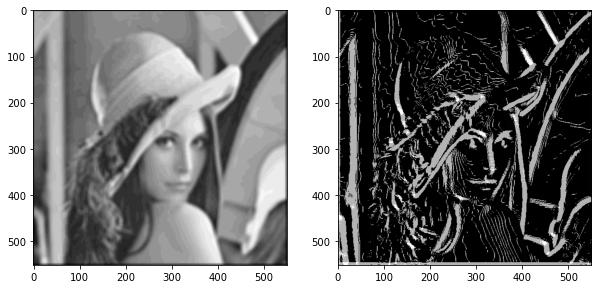

In [12]:
_, _, grad_sobel, angle= sobel_filters(filtered_img)
affiche(filtered_img, grad_sobel)

#### 2.2 -  STEP 2 : Suppression des non-maximaux 
L'interet de cette étape est de supprimer les contours redondants identifiés par le filtre de Sobel, en gardant seulement les pixels qui ont une intensité maximale le long de la direction du gradient. 

Un pixel peut avoir un total de 4 directions pour le gradient car il existe un total de 8 pixels voisins (voisinage de Moore).

Pour chaque pixel, on commence par vérifier son orientation. Ensuite, on va voir si ce pixel est plus intense que son voisin dans la direction de son gradient. Si c'est le cas, nous comparons le pixel avec son voisin dans la direction opposée. Si ce pixel a une intensité maximale par rapport à ses voisins dans les deux directions, alors c'est un maximum local. Ce pixel sera conservé. Dans tous les autres cas, ce n'est pas un maximum local et le pixel est supprimé.

In [13]:
def non_max_delete(image, theta):
    M, N = image.shape
    new = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
                q = 255
                r = 255

                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = image[i, j+1]
                    r = image[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = image[i+1, j-1]
                    r = image[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = image[i+1, j]
                    r = image[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = image[i-1, j-1]
                    r = image[i+1, j+1]

                if (image[i,j] >= q) and (image[i,j] >= r):
                    new[i,j] = image[i,j]
                else:
                    new[i,j] = 0
    return new

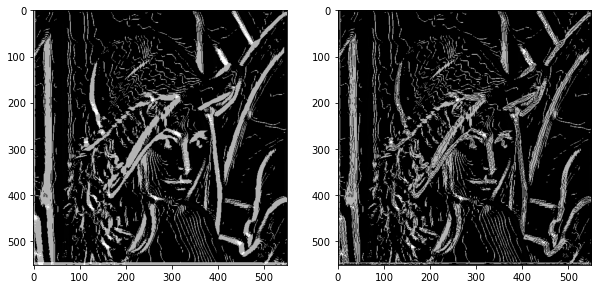

In [14]:
step2 = non_max_delete(grad_sobel, angle)
affiche(grad_sobel, step2)

#### 2.3 -  STEP 3 : Seuillage
L'idée principale de cette étape est de prendre tous les contours et de les définir comme étant soit faibles, soit forts. Nous définissons un seuil haut, au-dessus duquel les gradients sont considérés comme des contours forts. Tous les pixels dont le gradient dépasse ce seuil sont marqués comme des contours forts et sont généralement représentés en blanc (255). De même, nous définissons un seuil bas, en dessous duquel les gradients sont considérés comme des contours faibles. Ils sont conservés mais représentés avec une valeur plus faible (25), pour les distinguer des contours forts. 

In [15]:
def double_threshold(image, lowThresholdRatio=0.3, highThresholdRatio=0.7):
    
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    highThreshold = norm_image.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = image.shape
    new = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(norm_image >= highThreshold)
    zeros_i, zeros_j = np.where(norm_image < lowThreshold)
    
    weak_i, weak_j = np.where((norm_image <= highThreshold) & (norm_image >= lowThreshold))
    
    new[strong_i, strong_j] = strong
    new[weak_i, weak_j] = weak
    
    return new, weak, strong

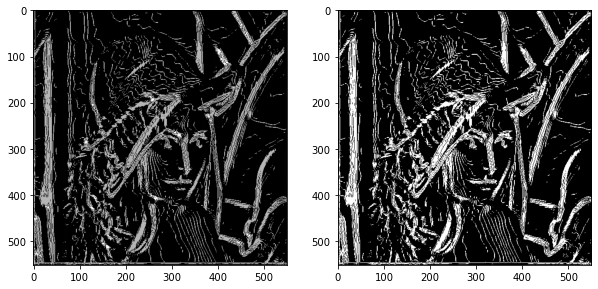

In [16]:
step3, weak, strong = double_threshold(step2, lowThresholdRatio=0.3, highThresholdRatio=0.7)
affiche(step2, step3)

#### 2.4 -  STEP 4: Seuillage par Hysteresis

Dans cette dernière étape, les pixels de contour faible qui sont connectés à des pixels de contour fort sont également considérés comme des contours forts. Cela permet de former des contours complets.

In [17]:
def hysteresis(image, weak, strong):
    M, N = image.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (image[i,j] == weak):
                if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                    or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                    or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0

    return image

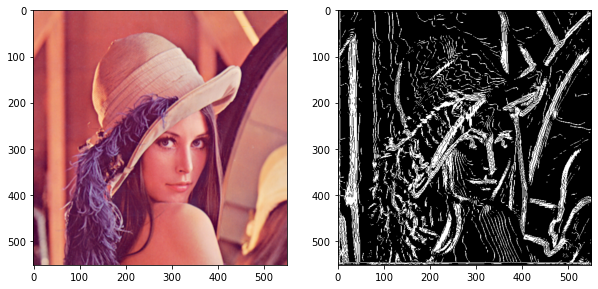

In [18]:
step4 = hysteresis(step3, weak, strong)
affiche(image, step4)

### 3 -  Filtrage par le filtre Laplacien
Les opérateurs de gradient vus précédemment exploitent le fait qu'un contour dans une image correspond au
maximum du gradient dans la direction orthogonale au contour. Or le passage par zéro de la dérivée seconde
d'une rupture d'intensité permet également de mettre en évidence le contour. 

Le Laplacien d'une image $I$ est le vecteur $$\nabla^2 I(x,y) $$défini par : 

$$\nabla^2 I(x,y) = (\frac{\delta^2{I(x,y)}}{\delta^2{x}}, \frac{\delta^2{I(x,y)}}{\delta^2{y}} ) ^t$$

La dérivée seconde est déterminée par le calcul du Laplacien qui peut être appliquée à une image par l'intermédiaire d'un filtrage
avec un masque $3*3$ donné ci-dessous.

In [19]:
def laplacian_filters(image,num_filters) :
    if num_filters == 1:
        filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    
    elif num_filters == 2:
        filter = np.array([[-1, -1, -1], [-1, -8, -1], [-1, -1, -1]])
        
    elif num_filters == 3:
        filter = np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])
        
    laplacian = convolve(image,filter)
    
    return laplacian

Les étapes pour la détection de contour est le même que pour le gradient, sauf que l'on n'a plus l'étape de suppression des non maximuns.
$\newline$
Il n'est d'ailleurs pas nécessaire de détecter spécifiquement les zéros car Le laplacien est calculé en appliquant un filtre qui met en évidence les variations d'intensité des pixels dans l'image. Les zones de forte variation d'intensité, qui indiquent généralement des contours, sont détectées à partir des valeurs positives et négatives résultantes du calcul du laplacien et du seuillage.

In [20]:
# Prétraitement avec un filtre gaussien
filtered_img = gaussian_kernel(image_niveau_gris, 10,10)

# Calcul du Laplacien 
laplacian = laplacian_filters(filtered_img,1)

# Seuillage par Hysteresis
new, weak, strong = double_threshold(laplacian, lowThresholdRatio=0.3, highThresholdRatio=0.7)
image_seuil = hysteresis(new, weak, strong)

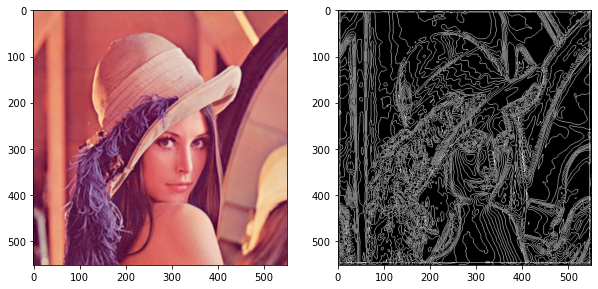

In [21]:
affiche(image,image_seuil)

### 4 -  Transformée de Hough 
Le filtre de Canny est souvent utilisé comme étape préliminaire pour détecter les contours, tandis que la transformée de Hough est une technique complémentaire utilisée pour extraire des formes spécifiques (lignes, cercles) à partir des contours détectés.

La transformée de Hough repose sur le principe de représentation des formes géométriques dans un espace de paramètres appelé espace de Hough. L'idée est de convertir chaque point de l'image qui appartient à une certaine forme géométrique en un ensemble de paramètres qui décrivent cette forme dans l'espace de Hough. 

Si deux points de contour se trouvent sur la même forme géométrique de l'image, leurs courbes sinusoïdales correspondantes s'intersecteront à une paire spécifique de paramètres dans l'espace de Hough. Ainsi, l'algorithme de transformation de Hough détecte les formes géométriques en recherchant les paires de paramètres qui ont un nombre d'intersections supérieur à un certain seuil.

Une fois que toutes les formes sont détectées dans l'espace de Hough, elles peuvent être récupérées en inversant la transformation de Hough. Cela implique de parcourir les points d'intersection dans l'espace de Hough et de les convertir en coordonnées d'image correspondantes.

Nous allons implémenter dans ce notebook seulement la transformée de Hough sur les lignes. D'autres transformée de Hough existent pour d'autres formes géométriques.

Toute ligne  est modélisé par l'équation en coordonnées polaire d'une droite : $\rho = xcos(\theta) + ysin(\theta)$.

Les limites de l'espace de Hough ont été représentées. Le point 0 est en bas à gauche de l'image. Les deux paramètres sont bornés. Si on note Nx et Ny les nombres de pixels horizontalement et verticalement, les domaines sont :
$\newline$
- $\rho \in [0, \sqrt{N_x^2 + N_y^2}]$
- $\theta \in [0^\circ, 180^\circ]$

La méthode de Hough repose sur l'utilisation d'une matrice accumulateur qui correspond à une discrétisation de ce domaine. 
Initialement, l'accumulateur est vide.

In [22]:
from math import sqrt

def calculate_rho_theta_range(edge_image_width, edge_image_height):
    d = sqrt(edge_image_width**2 + edge_image_height**2)
    rho_range = np.arange(-d, d,1)
    theta_range = np.arange(0,180,1)

    return rho_range, theta_range

def create_accumulator(num_rhos, num_thetas):
    accumulator = np.zeros((num_rhos, num_thetas))
    return accumulator

Pour chaque pixel M(x,y) de l'image, on incrémente dans l'accumulateur d'une unité les points de la courbe d'équation $\rho = xcos(\theta) + ysin(\theta)$.

Lorsque tous les points de l'image ont été traités, on sélectionne les éléments de l'accumulateur remplis au dessus d'un certain seuil, qui sont alors interprétés comme les paramètres de droites correspondant à des lignes sur l'image.

Le seuil est utilisé pour contrôler la sensibilité de la détection de lignes. Si on définit un seuil élevé, seules les lignes avec une forte accumulation seront détectées, ce qui peut conduire à une détection plus précise mais avec moins de lignes détectées. À l'inverse, si on définit un seuil plus bas, on peut détecter un plus grand nombre de lignes, mais cela peut également inclure des détections moins fiables ou du bruit.

In [24]:
import matplotlib.lines as mlines

# Entrée : 
#   edge_image, sortie d'un algorithme de détection de contours (ici Canny)
#   num_rhos, nombre de valeurs discrètes pour le paramètre ρ dans l'espace de Hough
#   num_thetas, nombre de valeurs discrètes ou de compartiments pour le paramètre θ
#   threshold, le seuil requis pour qu'une paire (ρ, θ) soit considérée comme une ligne

def hough_transform(edge_image, num_rhos = 180, num_thetas = 180, threshold = 3):
    Nx, Ny = edge_image.shape
    rho_range, theta_range = calculate_rho_theta_range(Nx,Ny)
    accumulator = create_accumulator(num_rhos,num_thetas)
    diagonal_length = sqrt(Nx**2 + Ny**2)
    
    # On itère sur tous les pixels de edge_image
    for y in range(Nx):
        for x in range(Ny):
            if edge_image[y, x] > 0:  # Vérification de si le pixel est un pixel contour
                for theta_index in range(num_thetas):
                    # On calcule la valeur de ρ correspondant pour le θ actuel
                    theta = np.deg2rad(theta_index / num_thetas * 180.0)
                    rho = x * np.cos(theta) + y * np.sin(theta)
                    rho_index = int((rho + diagonal_length) / (2 * diagonal_length) * num_rhos)
                    
                    # On incrémente l'accumulateur pour les indices de θ et de ρ correspondant
                    accumulator[rho_index, theta_index] += 1
                    
                    
                    
    figure = plt.figure(figsize=(12, 12))
    subplot1 = figure.add_subplot(1, 2, 1)
    subplot1.set_facecolor((0, 0, 0))
    subplot2 = figure.add_subplot(1, 2, 2)
    subplot2.imshow(edge_image)

    for y in range(accumulator.shape[0]):
        for x in range(accumulator.shape[1]):
              if accumulator[y][x] > threshold :
                    rho = rho_range[y]
                    theta = theta_range[x]
                    a = np.cos(np.deg2rad(theta))
                    b = np.sin(np.deg2rad(theta))

                    # Coordonnées de l'intersection de la ligne détectée (rho,theta) avec l'origine (0,0). 
                    # Il s'agit du point de la ligne détectée qui est le plus proche de l'origine.
                    x0 = (a * rho) + Nx/2
                    y0 = (b * rho) + Ny/2

                    # Coordonnées d'un point (x1,y1) sur le segment de gauche situé de l'autre côté 
                    # du point (x0, y0) et distant de 1000 unités dans la direction perpendiculaire.
   
                    x1 = int(x0 + 1000 * (-b))
                    y1 = int(y0 + 1000 * (a))

                    # Coordonnées d'un autre point (x2,y2) sur le segment de droite situé de l'autre côté 
                    # du point (x0, y0) et distant de 1000 unités dans la direction perpendiculaire.

                    x2 = int(x0 - 1000 * (-b))
                    y2 = int(y0 - 1000 * (a))

                    # On trace le point sur subplot1
                    subplot1.plot([theta], [rho], marker='o', color="red")
                    # On ajoute la ligne sur subplot2
                    subplot2.add_line(mlines.Line2D([x1, x2], [y1, y2], color = "green"))
    
    subplot1.invert_yaxis()
    subplot1.invert_xaxis()

  
    subplot1.title.set_text("Espace de Hough")
    subplot2.title.set_text("Lignes détectées")
    plt.show()

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


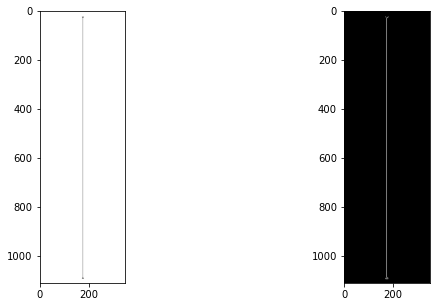

In [25]:
# Test
current_path = os.getcwd()
image_test = Image.open(current_path+'/trait.png')
image_niveau_gris_test = image_test.convert('L')
_, image2_test, grad, angle= sobel_filters(image_niveau_gris_test)
image3_test = non_max_delete(grad, angle)
new_test,_,_ = double_threshold(image3_test, lowThresholdRatio=0.3, highThresholdRatio=0.7)
image4_test = hysteresis(new_test, weak=25, strong=255)
affiche(image_test,image4_test)

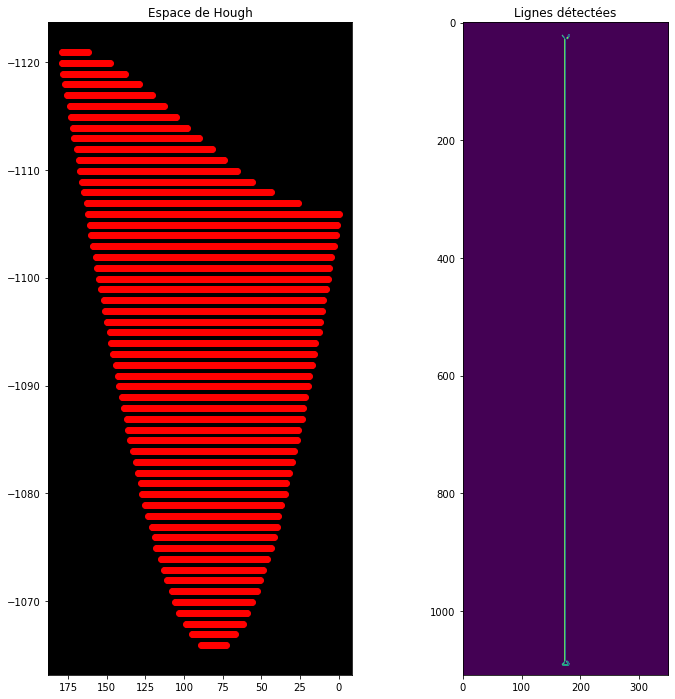

In [29]:
hough_transform(image4_test, 100)

Il doit avoir une erreur dans le plot car on devrait obtenir qu'un seul point dans l'espace de Hough.

# II- Détection de contours avec des méthodes de Deep Learning et Machine Learning

### 2.1 Méthodes de Machine Learning

Dans cette partie, nous allons essayer de prédire les contours d'une image en utilisant des algorithmes de Random Forest. \
Le jeu de données utilisé contient des images des rues de Barcelone. Ces images sont préalablement découpées et regroupées dans un dossier d'entraînement, accompagnées de leurs étiquettes respectives. Un autre dossier contient les images de test, également accompagnées de leurs étiquettes. \
Les étiquettes sont des images où les pixels sont marqués avec un 1 s'ils font partie d'un contour, et avec un 0 sinon.

L'algorithme de Random Forest est une méthode d'apprentissage automatique utilisée pour la classification et/ou la régression. Il fonctionne en créant un ensemble d'arbres de décision, où chaque arbre est construit de manière aléatoire. L'algorithme combine ensuite les prédictions de tous les arbres pour prendre une décision finale.

In [31]:
import matplotlib.image as mpimg

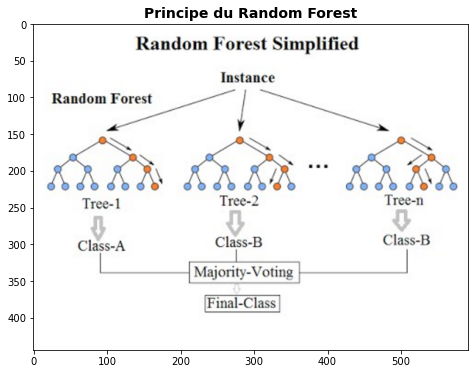

In [32]:
path_im = current_path + "/images/Random_forest_diagram_complete.png"
# Chargement de l'image depuis un fichier
im = mpimg.imread(path_im)
plt.figure(figsize=(9, 6))

plt.imshow(im)
plt.title("Principe du Random Forest",fontsize=14, fontweight='bold')
plt.show()


##### Random Forest Classifier

Puisque nos labels sont de type binaire, nous allons utiliser un algorithme de Random Forest Classifier, permettant de classifier les pixels de l'image (1 pour un contour et 0 sinon). 

In [33]:
import numpy as np
%matplotlib inline
import cv2, os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [34]:
# Import du dataset
current_path = os.getcwd()

DATADIR = current_path + "/BIPED/BIPED/edges/imgs"
PATH = current_path + "/BIPED/BIPED/edges/edge_maps"
path1 = os.path.join(DATADIR,"train/rgbr/real")
path2 = os.path.join(DATADIR,"test/rgbr/real")
path3 = os.path.join(PATH,"train/rgbr/real")
path4 = os.path.join(PATH,"test/rgbr/real")
X_train = []
X_test = []
y_train = []
y_test = []

new_shape=(500, 500)

for img in os.listdir(path1):  # iterate over each image by converting the scale
    img_array1 = cv2.imread(os.path.join(path1,img), cv2.IMREAD_GRAYSCALE)# cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array1, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    X_train.append(resized_img)
for img in os.listdir(path2):  # iterate over each image
    img_array2 = cv2.imread(os.path.join(path2,img), cv2.IMREAD_GRAYSCALE) # cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array2, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    X_test.append(resized_img)

for img in os.listdir(path3):  # iterate over each image
    img_array3 = cv2.imread(os.path.join(path3,img), cv2.IMREAD_GRAYSCALE) # cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array3, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    y_train.append(resized_img)
for img in os.listdir(path4):  # iterate over each image 
    img_array4 = cv2.imread(os.path.join(path4,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array4, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    y_test.append(resized_img)
    
# Mise sous forme np.array du dataset
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


On importe le dataset les mettant sous la forme souhaitée. \
Les pixels ayant une valeur de 1 sont considérés comme des contours, tandis que ceux ayant une valeur de 0 sont considérés comme n'étant pas des contours.

In [35]:
# Redimension des données en une seule dimension 
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

On redimensionne les données sur une seule dimension pour pouvoir appliquer l'agorithme de Random Forest

In [36]:
# Tri des images en fonction du nombre de pixels à 1 (en fonction du nombre de contours dans l'image)
pixels_a_1 = np.count_nonzero(y_train == 1, axis=1)
indices_tries = np.argsort(pixels_a_1)
y_train = y_train[indices_tries]
X_train = X_train[indices_tries]

On trie les images pour qu'on donne à l'algorithme le plus de contours possible et qu'il soit le plus performant possible.

<font color="red">**Attention :** Ne pas exécuter la cellule Python suivante !</font> 

Cette cellule contient un code qui nécessite une longue durée d'exécution (environ 60 à 100 minutes).

In [ ]:
# Entraînement du modèle
rf_classifier = RandomForestClassifier(n_estimators=20, random_state=42)
rf_classifier.fit(X_train, y_train)

In [ ]:
# Prédiction des contours pour les données de test
y_pred = rf_classifier.predict(X_test)

# Évaluation des performances du modèle
accuracy = np.mean(y_pred == y_test)
print("Précision du modèle :", accuracy)

La précision du modèle sur les données de test est très bonne, ce qui nous conforte dans le choix de notre type de Random Forest.

In [ ]:
# Prédiction des contours pour les données d'entrainement
y_pred = rf_classifier.predict(X_train)

# Évaluation des performances du modèle sur les données d'entrainement
accuracy = np.mean(y_pred == y_train)
print("Précision du modèle sur les données d'entrainement :", accuracy)

La précision du modèle est également excellente sur les données d'entrainement, ce qui est encourageant.

In [ ]:
image_index = 15

# Réorganiser l'image prédite pour correspondre à la forme originale
predicted_image = y_pred[image_index].reshape(500, 500)

# Afficher l'image prédite
plt.imshow(predicted_image)
plt.title("Image prédite")
plt.show()

# Réorganiser l'image prédite pour correspondre à la forme originale
test_image = y_test[image_index].reshape(500, 500)

# Afficher l'image prédite
plt.imshow(test_image)
plt.title("Image de base")
plt.show()

<font color="red">La cellule Python suivante va afficher les images enregistrés correspondants à l'entraînement précédent.</font> 

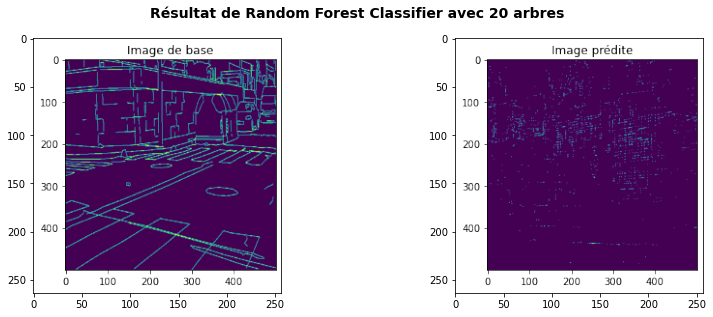

In [37]:
import matplotlib.image as mpimg

path_im1 = current_path + "/images/image_classifieur_base.png"
path_im2 = current_path + "/images/classifieur_predit.png"
# Chargement de l'image depuis un fichier
im1 = mpimg.imread(path_im1)
im2 = mpimg.imread(path_im2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image de base
ax1.imshow(im1)

# Afficher l'image prédite
ax2.imshow(im2)

plt.subplots_adjust(wspace=0.7, top=1.1)
plt.suptitle("Résultat de Random Forest Classifier avec 20 arbres",fontsize=14, fontweight='bold')
plt.show()

Néanmoins, afficher les images montre que l'algorithme semble ne pas très bien trouver les contours. \
L'algorithme semble trop prendre en compte les données d'entrainement sans jamais prendre en compte les données de test, ce qui s'apparente à du surapprentissage. Il se pourrait également que le dataset présente trop de pixels sans contours.

##### Random Forest Classifier avec un nombre différent d'arbres

Dans cette partie, nous allons essayer de comprendre si le fait que l'algorithme semble faire du surapprentissage vient du nombre d'arbres utilisés dans la forêt ou non.

In [38]:
import numpy as np
%matplotlib inline
import cv2, os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Import du dataset
current_path = os.getcwd()

DATADIR = current_path + "/BIPED/BIPED/edges/imgs"
PATH = current_path + "/BIPED/BIPED/edges/edge_maps"
path1 = os.path.join(DATADIR,"train/rgbr/real")
path2 = os.path.join(DATADIR,"test/rgbr/real")
path3 = os.path.join(PATH,"train/rgbr/real")
path4 = os.path.join(PATH,"test/rgbr/real")
X_train = []
X_test = []
y_train = []
y_test = []

new_shape=(500, 500)

for img in os.listdir(path1):  # iterate over each image by converting the scale
    img_array1 = cv2.imread(os.path.join(path1,img), cv2.IMREAD_GRAYSCALE)#,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array1, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    X_train.append(resized_img)
for img in os.listdir(path2):  # iterate over each image
    img_array2 = cv2.imread(os.path.join(path2,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array2, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    X_test.append(resized_img)

for img in os.listdir(path3):  # iterate over each image
    img_array3 = cv2.imread(os.path.join(path3,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array3, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    y_train.append(resized_img)
for img in os.listdir(path4):  # iterate over each image 
    img_array4 = cv2.imread(os.path.join(path4,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    #img_array4.resize(200,200)
    #y_test.append(np.array(cv2.resize(img_array4, new_shape, fx = 0.1, fy=0.1)))
    resized_img = cv2.resize(img_array4, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    y_test.append(resized_img)
    

# Mise sous forme np.array du dataset
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

On importe le dataset les mettant sous la forme souhaitée. \
Les pixels ayant une valeur de 1 sont considérés comme des contours, tandis que ceux ayant une valeur de 0 sont considérés comme n'étant pas des contours.

In [ ]:
# Redimension des données en une seule dimension 
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

On redimensionne les données sur une seule dimension pour pouvoir appliquer l'agorithme de Random Forest

In [ ]:
# Tri des images en fonction du nombre de pixels à 1 (en fonction du nombre de contours dans l'image)
pixels_a_1 = np.count_nonzero(y_train == 1, axis=1)
indices_tries = np.argsort(pixels_a_1)
y_train = y_train[indices_tries]
X_train = X_train[indices_tries]

On trie les images pour qu'on donne à l'algorithme le plus de contours possible et qu'il soit le plus performant possible.

Ici, on va essayer de comprendre ce que change le nombre d'arbres dans le Random Forest pour être certains qu'on n'est pas en suraprentissage.

<font color="red">**Attention :** Ne pas exécuter les cellules Python suivantes !</font> 

Cette cellule contient un code qui nécessite une longue durée d'exécution (environ 60 à 100 minutes).

In [ ]:
forest=[]
for i in range(1,15,2):
    # Entraînement du modèle
    rf_classifier = RandomForestClassifier(n_estimators=i, random_state=42)
    rf_classifier.fit(X_train[190:199,:], y_train[190:199])
    forest.append(rf_classifier)

In [ ]:
predictions = []
accuracies=[]
for i in range(1,15,2):
    # Prédiction des contours pour les données de test
    y_pred = rf_classifier.predict(X_test)
    predictions.append(y_pred)

    # Évaluation des performances du modèle
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

In [ ]:
plt.plot(accuracies*2)
plt.xlabel("Nombre d'arbres dans le Random Forest")
plt.ylabel("Accuracy sur les données de test")
plt.title("Accuracy du modèle en fonction du nombre d'arbres dans le Random Forest")
plt.show()

L'accuracy semble excellente pour n'importe quel nombre d'arbres dans la forêt ce qui est une assez bonne chose. \
Néanmoins, le fait que le nombre d'arbres ne fasse pas varier l'accuracy du modèle n'est pas très bon signe. \
Vérifions ça en visualisant les images prédictes en fonction du nombre d'arbres dans le modèle.

In [ ]:
image_index = 10

# Affichage des images en fonction du nombre d'arbres 
# A droite les images de base et à gauche la prédiction des différents modèles
fig, axes = plt.subplots(len(predictions), 2, figsize=(30, 30))

for i, ax in enumerate(axes.flat):
    if i % 2 == 0 :
        ax.imshow(y_test[image_index].reshape(500, 500))
    else :
        ax.imshow(predictions[i//2][image_index].reshape(500, 500))

plt.show()

En effet, en visualisant les prédictions des différents modèles (les prédictions sont à droite), il semble qu'ils prédisent à peu de choses près la même chose pour une même image.

Nous pouvons alors penser que nous sommes en sousapprentissage mais le temps d'exécution des algorithmes sur nos machines ne nous permet pas d'augmenter de façon significative le nombre d'arbres dans le modèle.

#### Random Forest Regressor

Le random forest regressor nous permet de faire de la régression et pouvoir avoir une prédiction moins stricte/qui peut trouver les contours faibles de l'image si les contours forts ne sont pas détectés. \
Cette approche paraît en théorie meilleure que la précédente car plus adaptée à notre problème de détection de contours mais voyons ce qu'il en est en pratique.

In [ ]:
import numpy as np
%matplotlib inline
import cv2, os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Import du dataset
current_path = os.getcwd()

DATADIR = current_path + "/BIPED/BIPED/edges/imgs"
PATH = current_path + "/BIPED/BIPED/edges/edge_maps"
path1 = os.path.join(DATADIR,"train/rgbr/real")
path2 = os.path.join(DATADIR,"test/rgbr/real")
path3 = os.path.join(PATH,"train/rgbr/real")
path4 = os.path.join(PATH,"test/rgbr/real")
X_train = []
X_test = []
y_train = []
y_test = []

new_shape=(100, 100)

for img in os.listdir(path1):  # iterate over each image by converting the scale
    img_array1 = cv2.imread(os.path.join(path1,img), cv2.IMREAD_GRAYSCALE)#,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array1, new_shape)  
    X_train.append(resized_img)
for img in os.listdir(path2):  # iterate over each image
    img_array2 = cv2.imread(os.path.join(path2,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array2, new_shape)  
    X_test.append(resized_img)

for img in os.listdir(path3):  # iterate over each image
    img_array3 = cv2.imread(os.path.join(path3,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array3, new_shape)  
    y_train.append(resized_img)
for img in os.listdir(path4):  # iterate over each image 
    img_array4 = cv2.imread(os.path.join(path4,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    #img_array4.resize(200,200)
    #y_test.append(np.array(cv2.resize(img_array4, new_shape, fx = 0.1, fy=0.1)))
    resized_img = cv2.resize(img_array4, new_shape)  
    y_test.append(resized_img)
    

# Mise sous forme np.array du dataset
X_train = np.array(X_train, dtype = int)/255
X_test = np.array(X_test, dtype = int)/255
y_train = np.array(y_train, dtype = int)/255
y_test = np.array(y_test, dtype = int)/255

On importe le dataset les mettant sous la forme souhaitée. \
Ici, les pixels ayant une valeur différente de 0 sont considérés comme des contours, tandis que ceux ayant une valeur de 0 sont considérés comme n'étant pas des contours.

In [ ]:
# Redimension des données en une seule dimension 
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

On redimensionne les données sur une seule dimension pour pouvoir appliquer l'agorithme de Random Forest

In [ ]:
# Tri des images en fonction du nombre de pixels à 1 (en fonction du nombre de contours dans l'image)
pixels_a_1 = np.count_nonzero(y_train == 1, axis=1)
indices_tries = np.argsort(pixels_a_1)
y_train = y_train[indices_tries]
X_train = X_train[indices_tries]

On trie les images pour qu'on donne à l'algorithme le plus de contours possible et qu'il soit le plus performant possible.

In [ ]:
# On enlève toutes les images sans contours (s'il y en a)
masque = np.any(y_train != 0, axis=1)
X_train = X_train[masque]
y_train = y_train[masque]

Il est possible que lors de la redimension des données, aucun contour ne reste dans cette méthode. On enlève donc les images sans contours.

Cette cellule contient un code qui nécessite une longue durée d'exécution (environ 60 à 100 minutes). \
Vous pouvez cependant lancer la cellule en enlevant des images d'entrainement pour l'entrainement du modèle.

In [ ]:
# Entraînement du modèle
rf_classifier = RandomForestRegressor(n_estimators=50, random_state=42)

# Si vous voulez run la cellule, commentez cette ligne et décommentez la ligne suivante
rf_classifier.fit(X_train[150:199,:], y_train[150:199])
# rf_classifier.fit(X_train[190:199,:], y_train[190:199])

In [ ]:
# Prédiction des contours pour les données d'entrainement
y_pred = rf_classifier.predict(X_test)

# Seuillage des prédictions
y_pred = y_pred>=0.1

# Évaluation des performances du modèle sur les données d'entrainement
accuracy = np.mean(y_pred == y_test)
print("Précision du modèle :", accuracy)

On entraine le modèle, on seuil les données pour avoir des binaires en sortie et on regarde la précision sur les images de test. \
Ici, on trouve une précision de 87%, ce qui est encourageant.

In [ ]:
image_index = 20

# Réorganiser l'image prédite pour correspondre à la forme originale
predicted_image = y_pred[image_index].reshape(100, 100)

# Afficher l'image prédite
plt.imshow(predicted_image)
plt.title("Image prédite")
plt.show()

# Réorganiser l'image prédite pour correspondre à la forme originale
test_image = y_test[image_index].reshape(100, 100)

# Afficher l'image prédite
plt.imshow(test_image)
plt.title("Image de base")
plt.show()

<font color="red">La cellule Python suivante va afficher les images enregistrés correspondants à l'entraînement précédent.</font> 

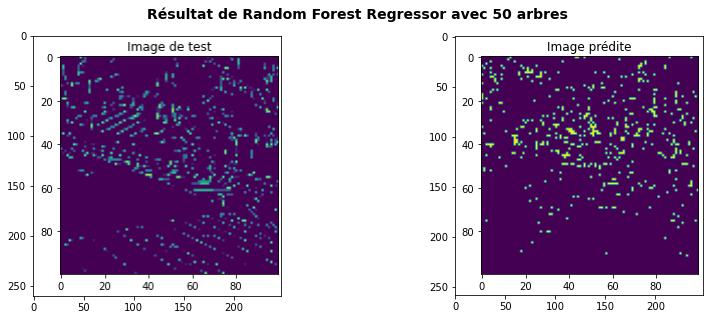

In [35]:
import matplotlib.image as mpimg

path_im1 = current_path + "/images/test_regression.png"
path_im2 = current_path + "/images/prediction_regression.png"
# Chargement de l'image depuis un fichier
im1 = mpimg.imread(path_im1)
im2 = mpimg.imread(path_im2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image de base
ax1.imshow(im1)

# Afficher l'image prédite
ax2.imshow(im2)

plt.subplots_adjust(wspace=0.7, top=1.1)
plt.suptitle("Résultat de Random Forest Regressor avec 50 arbres",fontsize=14, fontweight='bold')
plt.show()


La visualisation des images nous montre que l'algorithme prédit plutôt bien les images. Cependant, il faudrait avoir un de meilleurs labels pour en être certain car ici, le fait de vouloir avoir une régression et non une classification ne nous permet pas de charger les données comme auparavant, d'où le problème avec les labels.

##### Conclusion

Pour conclure, nous pouvons dire que les résultats de cette partie sont encourageants mais les algorithme prennent beaucoup de temps à s'entrainer pour des résultats bien moins bons que pour les méthodes classiques. \
Cependant, certaines études ont révélé qu'il est envisageable de détecter des contours à l'aide d'algorithmes de Random Forest. Pour ce faire, la méthode la plus efficace consiste à créer une forêt comprenant autant d'arbres que de pixels dans l'image. Chaque arbre est entraîné et utilisé pour prédire la valeur d'un pixel spécifique dans l'image. \
Néanmoins, cette méthode n'a pas pu être appliquée ici car prenant beaucoup trop de temps à tourner (on est à environ 100min pour 20 arbres et il faudrait un minimum de 2500 arbres).

### 2.2  Méthodes de Deep Learning

Dans cette partie, nous avons décidé d'explorer la détection de contours avec d'autres méthodes du milieu du Deep Learning. Dans un premier temps, vous trouverez une partie consacrée à l'étude de la détection de contours grâce à un réseau de neurones CNN (dont l'architecture à été inventée). Vous pourrez soit refaire la phase d'apprentissage avec la phase de test soit faire uniquement la phase de test avec les poids préalablement calculés.

Dans un deuxième temps, vous aurez la possibilité d'utiliser une méthode de transfer learning (plus précisemment du fine tuning) pour réaliser de la détection de contours.

In [44]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
import cv2, os
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as tvf

### 2.2.1 Détection de contours avec une architecture de CNN inventée

##### 1. Importation du dataset en s'insipirant du github : https://github.com/xavysp/DexiNed/blob/master/datasets.py 

Transformation de chaque image du dataset en tenseur (en héritant de la classe Dataset)

Différentes transformations : 
* Transformation des images en tenseur avec le première dimension qui correspond aux canaux RGB (ici on ne sélectionne qu'un seul canal pour avoir des images en niveau de gris).
* Transformation des tenseurs en taille 200*200 pour avoir des images de même taille.
* Normalisation des tenseurs pour avoir des valeurs de pixels entre 0 et 1. 

In [45]:
class BipedDataset(Dataset):
    train_modes = ['train', 'test', ]
    dataset_types = ['rgbr', ]
    data_types = ['real', ]

    def __init__(self,
                 data_root,
                 img_height,
                 img_width,
                 train_mode='train',
                 dataset_type='rgbr',
                 #  is_scaling=None,
                 # Whether to crop image or otherwise resize image to match image height and width.
                 crop_img=False,
                 arg=None
                 ):
        self.data_root = data_root
        self.train_mode = train_mode
        self.dataset_type = dataset_type
        self.data_type = 'real'
        self.img_height = img_height
        self.img_width = img_width
        self.crop_img = crop_img

        self.data_index = self._build_index()

    def _build_index(self):
        assert self.train_mode in self.train_modes, self.train_mode
        assert self.dataset_type in self.dataset_types, self.dataset_type
        assert self.data_type in self.data_types, self.data_type

        sample_indices = []

        images_path = os.path.join(self.data_root,
                                   'edges/imgs',
                                   self.train_mode,
                                   self.dataset_type)
        labels_path = os.path.join(self.data_root,
                                   'edges/edge_maps',
                                   self.train_mode,
                                   self.dataset_type)

        for directory_name in os.listdir(images_path):
            image_directories = os.path.join(images_path, directory_name)
            for file_name_ext in os.listdir(image_directories):
                file_name = os.path.splitext(file_name_ext)[0]
                sample_indices.append(
                    (os.path.join(images_path, directory_name, file_name + '.jpg'),
                     os.path.join(labels_path, directory_name, file_name + '.png'),)
                )

        return sample_indices

    def __len__(self):
        return len(self.data_index)

    def __getitem__(self, idx):
        #On sélectionne nos data
        image_path, label_path = self.data_index[idx]
        
        #On lit les images 
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        #On transforme ces images en tenseur
        image = torchvision.transforms.ToTensor()(image)
        label = torchvision.transforms.ToTensor()(label)

        #On transforme toutes nos images avec la même taille
        image = torchvision.transforms.Resize((200,200))(image)
        label = torchvision.transforms.Resize((200,200))(label)
        
        #On normalise les images entre 0 et 1
        image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
        label = (label - torch.min(label)) / (torch.max(label) - torch.min(label))

        #On sélectionne la première bande car on veut prédire un masque avec une seule bande 
        image = image[0:1,:,:]
        
        return dict(images=image, labels=label)

Transformation des images en dataloader (empilement de 8 tenseurs sur la 1ère dimension) on a donc des objets de taille (8,1,200,200)

In [46]:
current_path = os.getcwd()

train_dataset = BipedDataset(current_path+"/BIPED/BIPED",
                                     img_width=720,
                                     img_height=1280,
                                     train_mode='train',
                                     )
test_dataset = BipedDataset(current_path+"/BIPED/BIPED",
                                     img_width=720,
                                     img_height=1280,
                                     train_mode='test',
                                     )
#Transformation des images du dataset BIPED en Dataloader (empilement d'images de taille (8, 1, 200, 200))
trainloader = DataLoader(train_dataset, batch_size=8, num_workers=1)
testloader = DataLoader(test_dataset, batch_size=1, num_workers=1)

#### 2. Création de l'architecture du CNN

Définition de l'architecture du réseau de neurones en héritant de la classe torch.nn.Module. On définit une architecture autoencodeur  (l'encodeur construit de nouvelles représentations dites “encodées”. Le décodeur reçoit ces représentations et les traitent afin d’essayer de reconstruire les données de départ.)

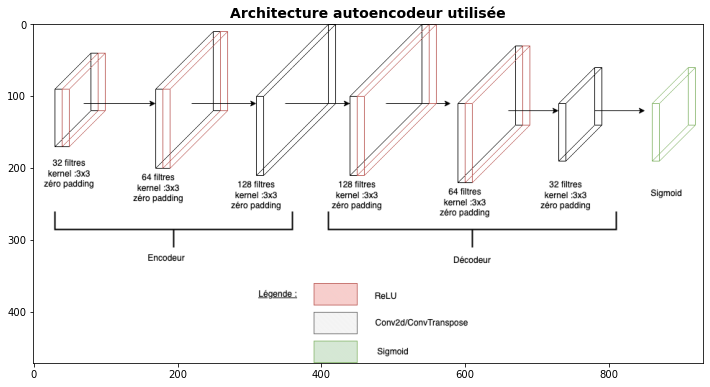

In [47]:
import matplotlib.image as mpimg

path_im = current_path + "/images/architecture_autoencodeur.png"
# Chargement de l'image depuis un fichier
im = mpimg.imread(path_im)
plt.figure(figsize=(12, 10))

plt.imshow(im)
plt.title("Architecture autoencodeur utilisée",fontsize=14, fontweight='bold')
plt.show()


In [48]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Partie encodeur constituée de 3 couches de convolutions (avec du zéro padding pour garder la taille de l'image de base)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
        )

        # Partie décodeur composée de 3 couches de déconvolution
        self.decodeur = nn.Sequential(

            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),

        )
        #Classifieur sigmoid pour transformer la sortie en probabilité pour faire un seuillage et savoir si le pixel est un contour ou non
        self.classifier = nn.Sigmoid()
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decodeur(x)
        x = self.classifier(x)
        return x

#### 3. Utilistion du GPU ou du CPU sur votre machine

ATTENTION : la prochaine cellule permet de choisir entre l'utilisation de CPU ou de GPU sur votre machine. Si vous possédez du GPU celui-ci sera utilisé, sinon on utilisera le CPU.

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Autoencoder()
net.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decodeur): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Sigmoid()
)

#### 4. Phase d'entraînement
<font color="red">La prochaine cellule est à exécuter uniquement si vous souhaitez faire la phase d'entraînement de 0. Temps d'entraînement d'environ 10 min sur GPU.</font> 


In [ ]:
current_path = os.getcwd()
net.train()
optimizer = torch.optim.SGD(params = net.parameters(),lr=0.1, momentum=0.9) # Optimiseur
criterion = nn.BCELoss() #Fonction Loss
num_epochs =150
for epoch in range(num_epochs): #On réalise 150 epochs
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    epoch_loss = 0.0
    epoch_corrects = 0
    loss_values = []
    for _, data in enumerate(tqdm(trainloader)): #On parcourt les données train
        net.to(device) #On ajoute le modèle et les données sur CPU/GPU
        img, label = data['images'].to(device), data['labels'].to(device)
        optimizer.zero_grad()
        outputs = net(img) #Les images train sont données en entrée du réseau
        loss_ =  criterion(outputs, label) # On calcule la loss
        loss_.backward() # backpropagation
        optimizer.step()
        output = (outputs>0.1).float() #Si la valeur du pixel est supérieur au seuil alors c'est un contour (1) sinon (0)
        acc = (output.cpu().detach().numpy() == label.cpu().detach().numpy()).mean()
   
    epoch_loss += loss_
    print('Epoch {} Loss : {}'.format((epoch+1),epoch_loss))
    print('Epoch {} Accuracy : {}'.format((epoch+1),acc))
torch.save(net.state_dict(), current_path + "/weights.pt")


#### 5. Phase de test 

In [50]:
current_path = os.getcwd()
path = current_path + "/weights.pt"
net.load_state_dict(torch.load(path, map_location=device))
criterion = nn.BCELoss()
with torch.no_grad():
    correct = 0
    total = 0
    loss_test =0
    net.eval()
    for _,data in enumerate(testloader):
        image, label = data['images'].to(device), data['labels'].to(device)
        outputs = net(image)
        loss = criterion(outputs, label)
        loss_test+=loss.item()
        output = (outputs>0.1).float()
        acc = (output.cpu().detach().numpy() == label.cpu().detach().numpy()).mean()
        
    test_loss=loss_test/len(test_dataset)
    print('Loss : {}'.format(test_loss))
    print('Accuracy : {}'.format(acc))

/home/mickael/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss : 0.11152099046856165
Accuracy : 0.928975


#### 6. Visualisation des feature maps

Dans cette partie nous visualisons les feature maps. Nous nous sommes inspirés du lien suivant : https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573. 
Ce sont les résultats obtenus entre la convolution d'un filtre (qui est appris par le réseau de neurones) et l'image d'entrée.

On re-crée l'architecture sans le nn.Sequentiel car on a besoin d'appeler chaque couche les unes après les autres pour pouvoir identifier les couches de convolution et déconvolution

In [51]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encodeur1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.encodeur2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.encodeur3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.decodeur1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.decodeur2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.decodeur3 = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)
        self.classifier = nn.Sigmoid()
        

    def forward(self, x):
        x = self.encodeur1(x)
        x = self.relu1(x)
        x = self.encodeur2(x)
        x = self.relu2(x)
        x = self.encodeur3(x)
        x = self.decodeur1(x)
        x = self.relu3(x)
        x = self.decodeur2(x)
        x = self.relu4(x)
        x = self.decodeur3(x)
        x = self.classifier(x)
        
        return x

Dans le code suivant vous devez mettre le chemin correspondant à l'emplacement du fichier weights_feature_maps.pt dans votre ordinateur

In [52]:
model = Autoencoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#On charge les poids de ce réseau préalablement entraîné  
current_path = os.getcwd()
path = current_path+ "/weights_feature_maps.pt"
model.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [53]:
model_weights =[]
conv_layers = []
model_children = list(model.children())
counter = 0
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d or type(model_children[i]) == nn.ConvTranspose2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 6
conv_layers


In [54]:
import cv2
current_path = os.getcwd()
lena = cv2.imread(current_path + "/lena.png",  cv2.IMREAD_COLOR )
lena = torchvision.transforms.ToTensor()(lena)
lena = lena[0:1, :,:]

In [55]:
out = []
names = []
for layer in conv_layers[0:]:
    lena = layer(lena)
    out.append(lena)
    names.append(str(layer))

In [56]:
processed = []
for feature_map in out:
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())


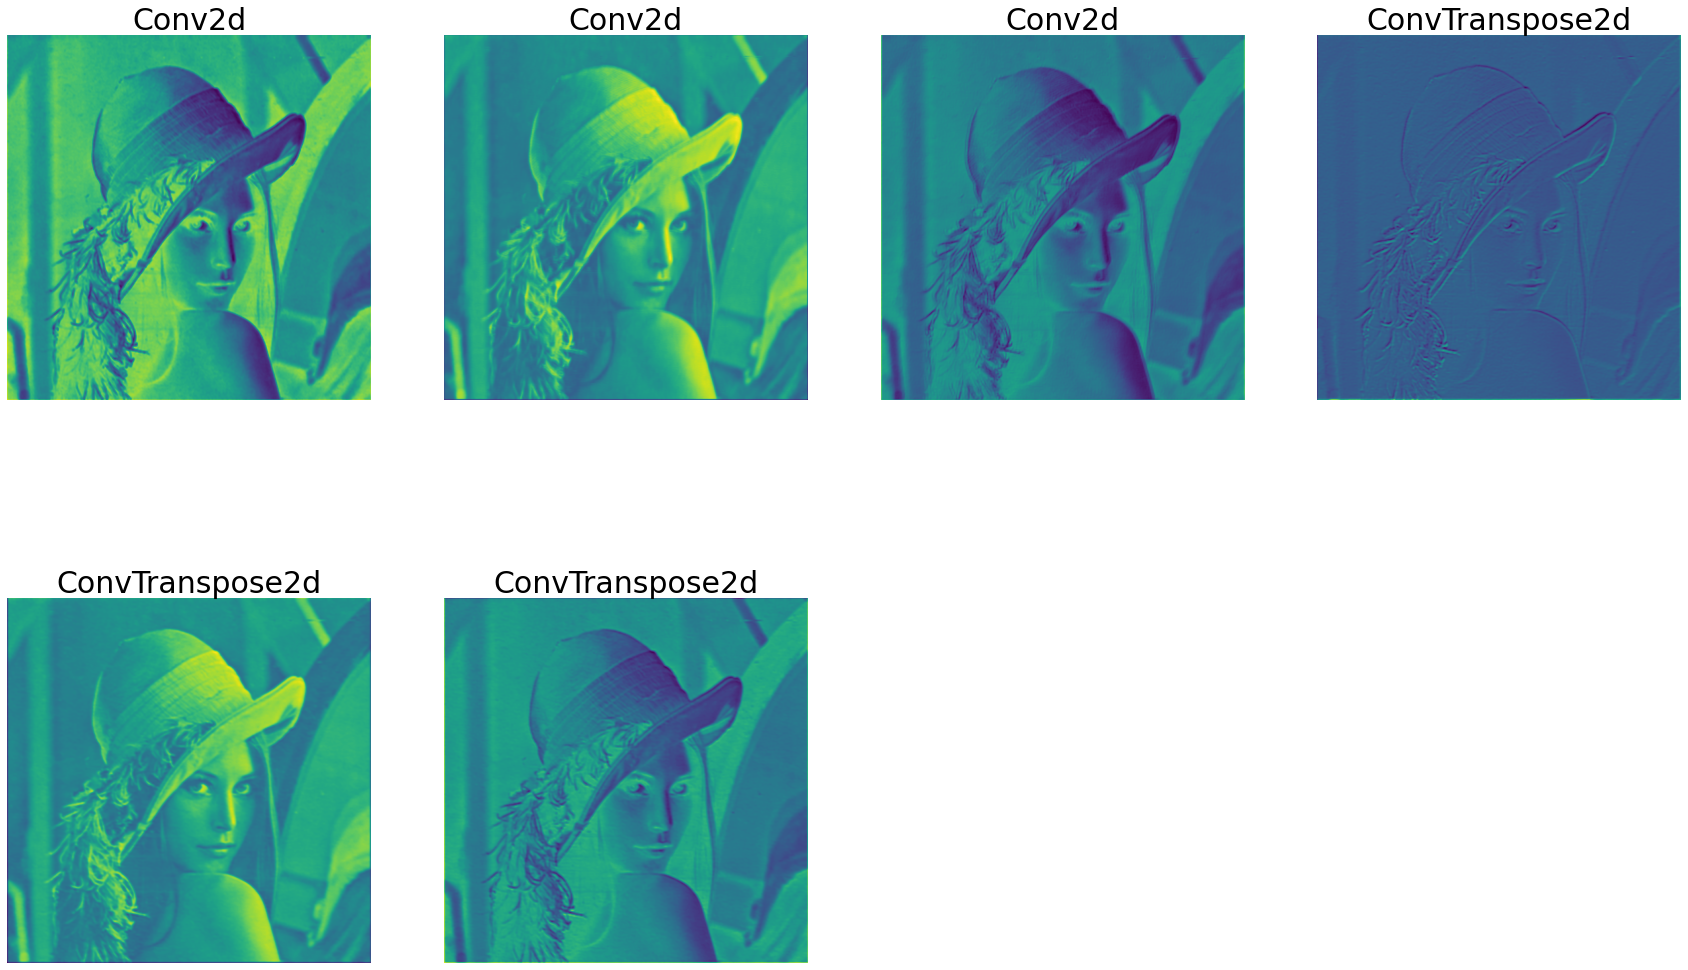

In [57]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

On voit donc que la troisième couche commence à capter les contours de l'image

<font color="red">La cellule Python suivante va afficher les images enregistrés correspondants aux features maps.</font> 

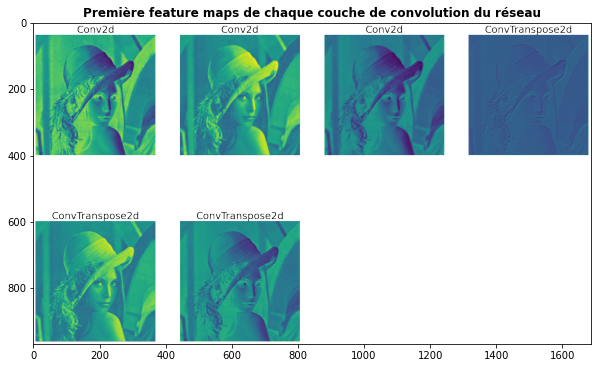

In [48]:
path_im = current_path + "/images/feature_maps.png"
# Chargement de l'image depuis un fichier
im = mpimg.imread(path_im)
plt.figure(figsize=(10, 6))

plt.imshow(im)
plt.title("Première feature maps de chaque couche de convolution du réseau",fontsize=12, fontweight='bold')
plt.show()

#### 7. Affichage des contours sur des images

Affichage des contours sur une image du dataset

In [58]:
outputs = output.cpu()

On change l'emplacement des dimensions pour avoir les canaux RGB sur la 3ème dimension

In [59]:
outputs = outputs.detach().numpy()
outputs = outputs[0,:,:,:]
outputs = np.swapaxes(outputs, 0, 1)
outputs= np.swapaxes(outputs, 1,2)

On seuille la prédiction du réseau pour obtenir les contours

In [60]:
threshold = 0.10
y_pred = (outputs > threshold) # 0.0 or 1.0

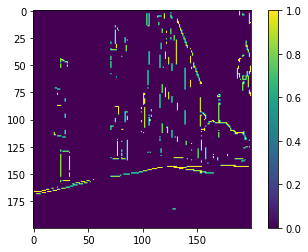

In [61]:
plt.imshow(y_pred)
plt.colorbar()

Comparaison avec le label 

In [62]:
labels = label.cpu().detach().numpy()
labels = labels[0,:,:,:]
labels = np.swapaxes(labels, 0, 1)
labels= np.swapaxes(labels, 1,2)

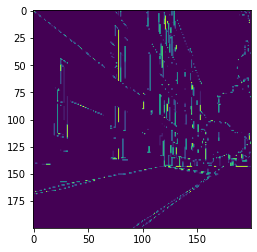

In [63]:
plt.imshow(labels)

<font color="red">La cellule Python suivante va afficher les images enregistré correspondants aux contours détéctés grâce à notre CNN sur une image du dataset test.</font> 

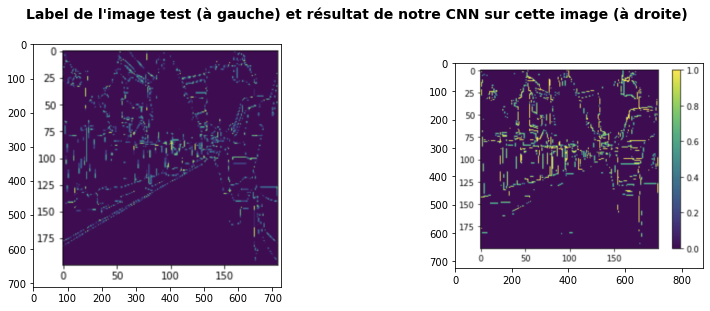

In [55]:
path_im1 = current_path + "/images/label_dataset.png"
path_im2 = current_path + "/images/image_predite_dataset.png"
# Chargement de l'image depuis un fichier
im1 = mpimg.imread(path_im1)
im2 = mpimg.imread(path_im2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image de base
ax1.imshow(im1)

# Afficher l'image prédite
ax2.imshow(im2)

plt.subplots_adjust(wspace=0.7, top=1.1)
plt.suptitle("Label de l'image test (à gauche) et résultat de notre CNN sur cette image (à droite)",fontsize=14, fontweight='bold')
plt.show()


Affichage des contours sur une image qui n'est pas du dataset


In [ ]:
current_path = os.getcwd()
lena = cv2.imread(current_path+"/lena.png",  cv2.IMREAD_COLOR )

On transforme l'image en tenseur Pytorch pour qu'elle puisse passer dans le réseau

In [ ]:
lena = torchvision.transforms.ToTensor()(lena)

On passe l'image dans le réseau

In [ ]:
outputs = net(lena[0:1, :,:].to(device))

On change les dimensions pour avoir les canaux RGB sur la 3ème dimension

In [ ]:
labels = outputs.cpu().detach().numpy()
labels = np.swapaxes(labels, 0, 1)
labels= np.swapaxes(labels, 1,2)

On seuille la prédiction pour obtenir les contours

In [ ]:
threshold = 0.05
y_pred = (labels > threshold)

In [ ]:
plt.imshow(y_pred)

<font color="red">La cellule Python suivante va afficher l'image enregistré correspondants aux contours détéctés grâce à notre CNN sur l'image Lenna.</font> 

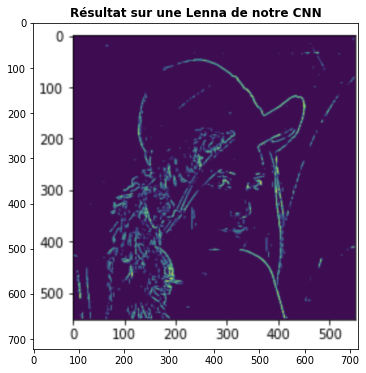

In [51]:
path_im = current_path + "/images/lena_autoencodeur.png"
# Chargement de l'image depuis un fichier
im = mpimg.imread(path_im)
plt.figure(figsize=(10, 6))

plt.imshow(im)
plt.title("Résultat sur une Lenna de notre CNN",fontsize=12, fontweight='bold')
plt.show()

### 2.2.2 Détection de contours avec du fine tuning

Dans cette partie nous réalisons du fine tuning. Cela consiste à utiliser un réseau de neurones entraîné sur une tâche différente à celle de la détection de contours et à réutiliser les poids de celui-ci pour réaliser une nouvelle phase d'apprentissage cette fois-ci spécifique à la détection de contours.

1. Chargement des données 
On refait le chargement des données (il faut que les images soient un multiple de 32)

In [64]:
class BipedDataset(Dataset):
    train_modes = ['train', 'test', ]
    dataset_types = ['rgbr', ]
    data_types = ['real', ]

    def __init__(self,
                 data_root,
                 img_height,
                 img_width,
                 train_mode='train',
                 dataset_type='rgbr',
                 #is_scaling=None,
                 crop_img=False,
                 arg=None
                 ):
        self.data_root = data_root
        self.train_mode = train_mode
        self.dataset_type = dataset_type
        self.data_type = 'real'  # be aware that this might change in the future
        self.img_height = img_height
        self.img_width = img_width
        self.crop_img = crop_img

        self.data_index = self._build_index()

    def _build_index(self):
        assert self.train_mode in self.train_modes, self.train_mode
        assert self.dataset_type in self.dataset_types, self.dataset_type
        assert self.data_type in self.data_types, self.data_type

        #data_root = os.path.abspath(self.data_root)
        sample_indices = []

        images_path = os.path.join(self.data_root,
                                   'edges/imgs',
                                   self.train_mode,
                                   self.dataset_type)
        labels_path = os.path.join(self.data_root,
                                   'edges/edge_maps',
                                   self.train_mode,
                                   self.dataset_type)

        for directory_name in os.listdir(images_path):
            image_directories = os.path.join(images_path, directory_name)
            for file_name_ext in os.listdir(image_directories):
                file_name = os.path.splitext(file_name_ext)[0]
                sample_indices.append(
                    (os.path.join(images_path, directory_name, file_name + '.jpg'),
                     os.path.join(labels_path, directory_name, file_name + '.png'),)
                )

        return sample_indices

    def __len__(self):
        return len(self.data_index)

    def __getitem__(self, idx):
        #On sélectionne nos data
        image_path, label_path = self.data_index[idx]
        
        #On lit les images 
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        #On transforme ces images en tenseur
        image = torchvision.transforms.ToTensor()(image)
        label = torchvision.transforms.ToTensor()(label)

        #On transforme toutes nos images avec la même taille
        image = torchvision.transforms.Resize((384,384))(image)
        label = torchvision.transforms.Resize((384,384))(label)
        
        #On normalise les images entre 0 et 1
        image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
        label = (label - torch.min(label)) / (torch.max(label) - torch.min(label))

        #On sélectionne la première bande car on veut prédire un masque avec une seule bande 
        image = image[0:1,:,:]
        
        return dict(images=image, labels=label)

In [65]:
current_path = os.getcwd()

train_dataset = BipedDataset(current_path+"/BIPED/BIPED",
                                     img_width=720,
                                     img_height=1280,
                                     train_mode='train',
                                     )
test_dataset = BipedDataset(current_path+"/BIPED/BIPED",
                                     img_width=720,
                                     img_height=1280,
                                     train_mode='test',
                                     )
#Transformation des images du dataset BIPED en Dataloader (empilement d'images de taille (8, 1, 200, 200))
trainloader = DataLoader(train_dataset, batch_size=8, num_workers=1)
testloader = DataLoader(test_dataset, batch_size=1, num_workers=1)

2. Chargment du réseau de neurones U-Net 

Ce réseau de neurones à été entraîné sur une tâche de segmentation. 

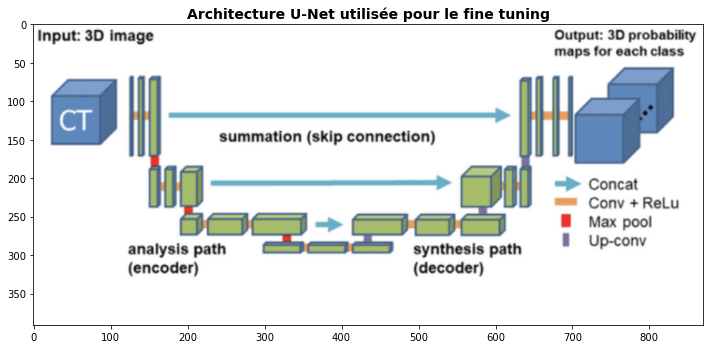

In [66]:
path_im = current_path + "/images/unet.png"
# Chargement de l'image depuis un fichier
im = mpimg.imread(path_im)
plt.figure(figsize=(12, 10))

plt.imshow(im)
plt.title("Architecture U-Net utilisée pour le fine tuning",fontsize=14, fontweight='bold')
plt.show()


Ici on change juste la première couche en une couche de convolution qui prend une seule bande en entrée 

In [67]:
import torchvision.models.densenet
#On télécharge le modèle pré-entraîné
net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
net.encoder1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

/home/mickael/.local/lib/python3.10/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /home/mickael/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /home/mickael/.cache/torch/hub/checkpoints/unet-e012d006.pt


3. Utilisation du GPU/CPU

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

4. Phase d'entraînement

On réalise une phase d'entraînement du réseau Unet pour le spécialiser dans une tâche de détection de contours

<font color="red">La prochaine cellule est à exécuter uniquement si vous souhaitez faire la phase d'entraînement de 0. Temps d'entraînement d'environ 5 min sur GPU.</font> 

In [ ]:
net.train()
optimizer = torch.optim.SGD(params = net.parameters(),lr=0.1, momentum=0.9)
criterion = nn.BCELoss()
num_epochs =150
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    epoch_loss = 0.0
    epoch_corrects = 0
    loss_values = []
    for _, data in enumerate(tqdm(trainloader)):
        net.to(device)
        img, label = data['images'].to(device), data['labels'].to(device)
        optimizer.zero_grad()
        outputs = net(img)
        loss_ =  criterion(outputs, label)
        loss_.backward()
        optimizer.step()
        output = (outputs>0.1).float()
        acc = (output.cpu().detach().numpy() == label.cpu().detach().numpy()).mean()
        
    loss_values.append(loss_ / len(trainloader))
    epoch_loss += loss_
    print('Epoch {} Loss : {}'.format((epoch+1),epoch_loss))
    print('Epoch {} Accuracy : {}'.format((epoch+1),acc))
current_path = os.getcwd()
torch.save(net.state_dict(), current_path+"weights_unet_updated.pt")

#### 5. Phase de test 

In [69]:
current_path = os.getcwd()
path = current_path + "/weights_unet_updated.pt"
net.load_state_dict(torch.load(path, map_location=device))
net.to(device)
criterion = nn.BCELoss()
with torch.no_grad():
    correct = 0
    total = 0
    loss_test =0
    net.eval()
    for _,data in enumerate(testloader):
        image, label = data['images'].to(device), data['labels'].to(device)
        outputs = net(image)
        loss = criterion(outputs, label)
        loss_test+=loss.item()
        output = (outputs>0.1).float()
        acc = (output.cpu().detach().numpy() == label.cpu().detach().numpy()).mean()
        
    test_loss=loss_test/len(test_dataset)
    print('Loss : {}'.format(test_loss))
    print('Accuracy : {}'.format(acc))

/home/mickael/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss : 0.12258004236966372
Accuracy : 0.9245673285590278


#### 6. Résultat d'une image test du dataset

In [70]:
outputs = output.cpu()

On change les dimensions pour avoir les canaux RGB sur la 3ème dimension

In [71]:
outputs = outputs.detach().numpy()
outputs = outputs[0,:,:,:]
outputs = np.swapaxes(outputs, 0, 1)
outputs= np.swapaxes(outputs, 1,2)

On seuille pour obtenir les contours

In [ ]:
threshold = 0.10
y_pred = (outputs > threshold) # 0.0 or 1.0

In [ ]:
plt.imshow(outputs)
plt.colorbar()

<font color="red">La cellule Python suivante va afficher les images enregistré correspondants aux contours détéctés grâce à notre fine tuning sur U-Net sur une image du dataset test.</font> 

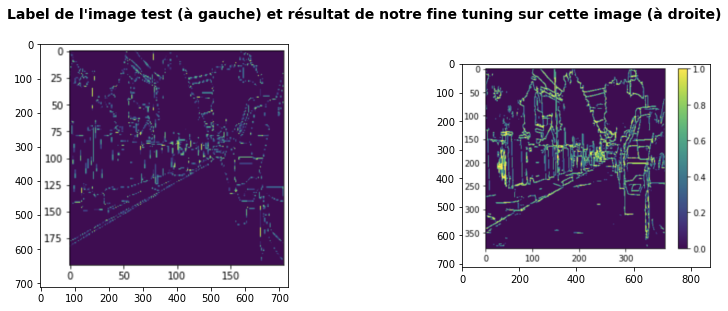

In [59]:
path_im1 = current_path + "/images/label_dataset.png"
path_im2 = current_path + "/images/image_predite_unet.png"
# Chargement de l'image depuis un fichier
im1 = mpimg.imread(path_im1)
im2 = mpimg.imread(path_im2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image de base
ax1.imshow(im1)

# Afficher l'image prédite
ax2.imshow(im2)

plt.subplots_adjust(wspace=0.7, top=1.1)
plt.suptitle("Label de l'image test (à gauche) et résultat de notre fine tuning sur cette image (à droite)",fontsize=14, fontweight='bold')
plt.show()


#### 7. Résultat d'une image Lénna qui n'est pas une image du dataset

In [72]:
current_path = os.getcwd()
lena = cv2.imread(current_path+"/lena.png",  cv2.IMREAD_COLOR )

On transforme en tenseur et on resize en (384, 384)

In [73]:
lena = torchvision.transforms.ToTensor()(lena)
lena = torchvision.transforms.Resize((384,384))(lena)
lena = torch.unsqueeze(lena, 1)

/home/mickael/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


On passe l'image dans le réseau pour prédire les contours

In [74]:
outputs = net(lena[0:1, :,:].to(device))

On échange l'ordre des dimensions pour avoir les canaux RGB à la fin

In [75]:
labels = outputs.cpu().detach().numpy()
labels = labels[0,:,:,:]
labels = np.swapaxes(labels, 0, 1)
labels= np.swapaxes(labels, 1,2)

On seuil le résultat de la prédiction pour obtenir les contours

In [76]:
threshold = 0.05
y_pred = (labels > threshold)

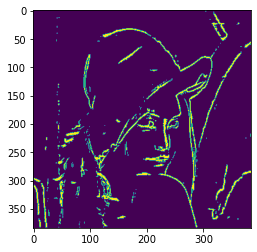

In [77]:
plt.imshow(y_pred)

<font color="red">La cellule Python suivante va afficher l'image enregistré correspondants aux contours détéctés grâce à notre fine tuning sur U-Net sur l'image Lenna.</font> 

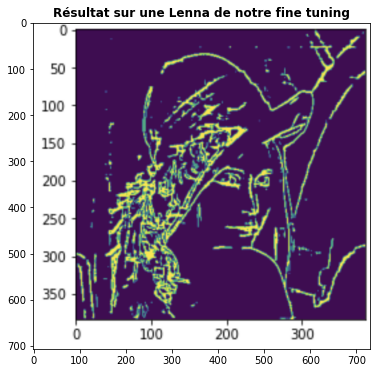

In [78]:
path_im = current_path + "/images/lena_unet.png"
# Chargement de l'image depuis un fichier
im = mpimg.imread(path_im)
plt.figure(figsize=(10, 6))

plt.imshow(im)
plt.title("Résultat sur une Lenna de notre fine tuning",fontsize=12, fontweight='bold')
plt.show()

### 2.3 Segmentation et détection de contours 

Dans cette partie nous allons comparer la sortie obtenue par le réseau unet (spécialisé dans de la détection de contours) et la sortie du réseau unet ré-entraîné pour réaliser de la détection de contours

In [79]:
import torchvision.models.densenet
#On télécharge le modèle pré-entraîné
net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/mickael/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [80]:
import numpy as np
from PIL import Image
from torchvision import transforms
current_path = os.getcwd()
input_image = cv2.imread(current_path + "/lena.png",  cv2.IMREAD_COLOR )
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=m, std=s),
    transforms.Resize((256,256))
    
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    net = net.to('cuda')

with torch.no_grad():
    output = net(input_batch)


In [81]:
res = torch.round(output[0]).cpu().detach().numpy()
res= np.swapaxes(res , 0,1)
res = np.swapaxes(res, 1,2)

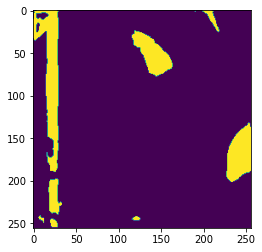

In [82]:
plt.imshow(res)

### 2.4 Test en faisant des transformation d'une image

Floutage d'une image

In [ ]:
current_path = os.getcwd()
input_image = cv2.imread(current_path+"/lena.png",  cv2.IMREAD_COLOR )
#input_image = torch.from_numpy(input_image)

def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [ ]:
net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
net.encoder1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
current_path = os.getcwd()
path = current_path+"/weights_unet_updated.pt"
net.load_state_dict(torch.load(path))

In [ ]:
noise_imgs = [add_noise(torchvision.transforms.ToTensor()(input_image),0.05)]


In [ ]:
noise_imgs = noise_imgs[0][0:1,:,:]
noise_imgs = torch.unsqueeze(noise_imgs, 0)

In [ ]:
noise_imgs = torchvision.transforms.Resize((384,384))(noise_imgs)

On passe l'image dans le réseau

In [ ]:
outputs = net(noise_imgs)

On change les dimensions pour avoir les canaux sur la 3ème dimension

In [ ]:
labels = outputs.cpu().detach().numpy()
labels = labels[0,:,:,:]
labels = np.swapaxes(labels, 0, 1)
labels= np.swapaxes(labels, 1,2)

On seuille pour avoir les contours

In [ ]:
threshold = 0.1
y_pred = (labels > threshold)

In [ ]:
plt.imshow(y_pred)

Image bruitée initiale

In [ ]:
noise_imgs = noise_imgs[0].numpy()
noise_imgs = np.swapaxes(noise_imgs, 0,1)
noise_imgs = np.swapaxes(noise_imgs, 1,2)

In [ ]:
plt.imshow(noise_imgs)

<font color="red">La cellule Python suivante va afficher les images enregistré correspondants aux contours détéctés grâce à notre fine tuning sur U-Net sur une image bruitée de Lenna.</font> 

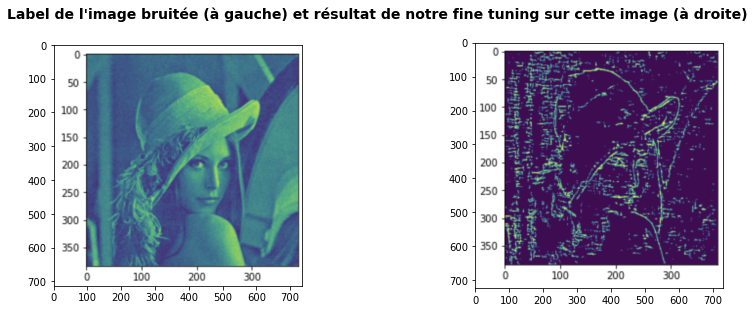

In [64]:
path_im1 = current_path + "/images/lena_bruitee.png"
path_im2 = current_path + "/images/lena_bruit.png"
# Chargement de l'image depuis un fichier
im1 = mpimg.imread(path_im1)
im2 = mpimg.imread(path_im2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image de base
ax1.imshow(im1)

# Afficher l'image prédite
ax2.imshow(im2)

plt.subplots_adjust(wspace=0.7, top=1.1)
plt.suptitle("Label de l'image bruitée (à gauche) et résultat de notre fine tuning sur cette image (à droite)",fontsize=14, fontweight='bold')
plt.show()
